<a href="https://colab.research.google.com/github/liz-lewis-manchester/CNM_2025_group_11/blob/main/coursework_computing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter end of time domain (s): 300
Enter temporal resolution dt (s): 10
Enter spatial resolution (m): 1
Enter the flow speed (m/s): 0.1
Upload your initial conditions CSV file:


Saving task 1 conditions.csv to task 1 conditions (4).csv


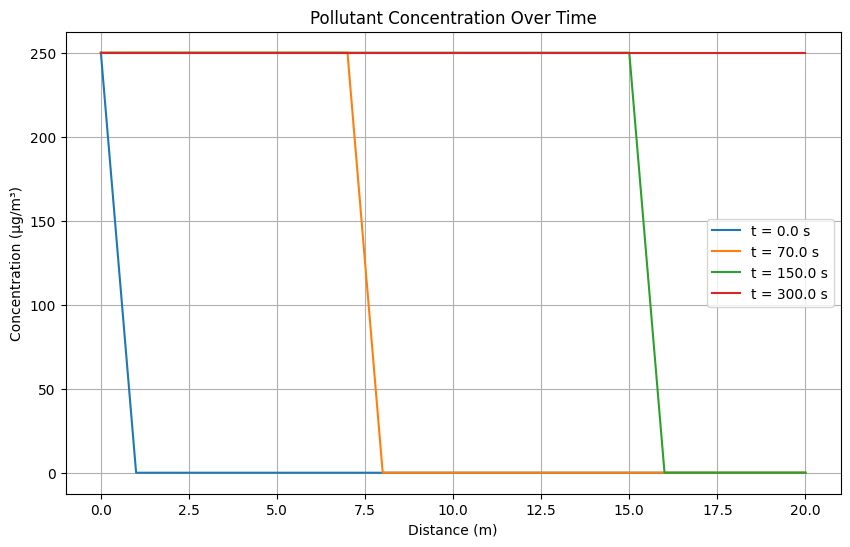

In [8]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files # for uploading the initial conditions CSV file

# ask user for temporal domain data
t_start = 0
t_end = float(input("Enter end of time domain (s): "))
dt = float(input("Enter temporal resolution dt (s): "))

# ask user for spatial resolution
dx = float(input("Enter spatial resolution (m): "))

# ask user for flow speed
U = float(input("Enter the flow speed (m/s): "))

# ask user for the decay constant for exponential decay
lambda_decay = float(input("Enter the decay constant (1/s): "))

# ask user to upload the initial conditions CSV
print("Upload your initial conditions CSV file:")
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

# loads distance and concentration data from CSV
file_data = np.loadtxt(file_name, delimiter=',', skiprows=1, encoding='latin1')
csv_x = file_data[:, 0]
csv_theta = file_data[:, 1]

# create a uniform spatial grid based on dx
x = np.arange(np.min(csv_x), np.max(csv_x) + dx, dx)

# interpolate concentration data onto the model
theta = np.interp(x, csv_x, csv_theta)
theta0 = theta[0] # store the initial upstream concentration for use in decay

# CFL stability check
C = U * dt / dx
if C > 1:
    new_dt = dx / U
    print(f"The CFL condition has been violated, temporal resolution has been adjusted to {new_dt:.4f} s")
    dt = new_dt

# initialise the time domain
t = np.arange(t_start, t_end + dt, dt)

# finite difference method
def FDM(theta, U, dt, dx):

    C = U * dt / dx

    new_theta = np.zeros_like(theta)

    for i in range (1, len(theta) - 1):
      new_theta[i] = theta[i] - C * (theta[i] - theta[i - 1])

    # boundary conditions
    new_theta[-1] = new_theta[-2]

    return new_theta

# run the simulation
results = np.zeros((len(t), len(x)))
results[0, :] = theta

for n in range(1, len(t)):

    theta = FDM(theta, U, dt, dx)

    theta[0] = np.interp(0, csv_x, csv_theta)

    results[n, :] = theta

# plot results at selected times snapshots
plt.figure(figsize=(10,6))
snapshot_times = [0, len(t)//4, len(t)//2, len(t)-1]  # 0%, 25%, 50%, 100% through time

for s in snapshot_times:
    plt.plot(x, results[s], label=f"t = {t[s]} s")

plt.xlabel("Distance (m)")
plt.ylabel("Concentration (µg/m³)")
plt.title("Pollutant Concentration Over Time")
plt.legend()
plt.grid()
plt.show()